In [360]:
#######Manipulação de dados e cálculos estatísticos
import pandas as pd
import numpy as np

####### Padronização de respostas rest
import json
import mysql.connector
import array

####### Api de consulta de Índices e CriptoMoeda
import yfinance as yf
from mercado_bitcoin import DataAPI

####### Formatação de datas
import datetime as dt

####### Visualização de dados
from bokeh.models import BooleanFilter, CDSView, Select, Range1d, HoverTool
from bokeh.io import curdoc, push_notebook, show, output_notebook
from bokeh.models.formatters import NumeralTickFormatter
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models.widgets import Dropdown
from bokeh.layouts import column, row
from bokeh.palettes import Category20
import matplotlib.pyplot as plt
import seaborn as sns
import os

####### Pré-Processamento 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA

###### Decomposição de séries temporais
from statsmodels.tsa.seasonal import seasonal_decompose


#preparação dos dados
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


# seção dos ensembles
from sklearn.ensemble import VotingClassifier

#métricas
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


###### Modelos
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Declaração de Funções

In [324]:
### Fornece uma conexão ativa à base de dados mysql
def getConnection():
    my_db = mysql.connector.connect(
      host="localhost",
      user="root",
      password="root",
      database="coindb",
      port="8889"
    )
    return my_db

### Padroniza os objetos manipulados para permitir interoperabilidade entre as funções
class Sumary():
    def __init__(self, coin, date, opening, closing, lowest, highest, volume, quantity, amount, avg_price):
        self.coin = coin
        self.date = date
        self.opening = opening
        self.closing = closing
        self.lowest = lowest
        self.highest = highest
        self.volume = volume
        self.quantity = quantity
        self.amount = amount
        self.avg_price = avg_price

### Possibilita a criação da estrutura das tabelas no banco de dados
def create_table(coin_name):
    print()
    command = f"CREATE TABLE {coin_name}_day_sumary (id int(11) NOT NULL PRIMARY KEY AUTO_INCREMENT, coin varchar(5) NOT NULL, date date NOT NULL, opening double NOT NULL, closing double NOT NULL, lowest double NOT NULL, highest double NOT NULL, volume double NOT NULL, quantity double NOT NULL, amount double NOT NULL, avg_price double NOT NULL)"
    cnn = getConnection()
    cnn.cursor().execute(f"drop table if exists {coin_name}_day_sumary;")
    cnn.commit()
    cnn.cursor().execute(command)
    cnn.commit()

### Solicita uma lista de papéis ou índices com base em uma data inicial até os dias de hoje
def getStock(stock_array, date_init):
    bag_amount = 20
    bag_control = 0
    date_now = dt.date.today()
    for stock in stock_array:
        bag_control = 0
        cnn = getConnection()
        create_table(stock)
        tickerData = yf.Ticker(stock)
        tickerDf = pd.DataFrame(tickerData.history(start=date_init.strftime("%Y-%m-%d"), end=date_now.strftime("%Y-%m-%d")))
       
        for index, stk in tickerDf.iterrows():
           
            try:
                command = f"INSERT INTO {stock}_day_sumary (coin, date, opening, closing, lowest, highest, volume, quantity, amount, avg_price) values ('{stock}', '{index}', '{stk.Open}', '{stk.Close}', '{stk.Low}', '{stk.High}', '{stk.Volume}', '0', '0', '0')"
                print(command)
                cnn.cursor().execute(command)
                if (bag_control >= bag_amount):
                    cnn.commit()
                    bag_control = 0
                    #print(calc_date)
            except Exception as e:
                print(e)
                continue
        cnn.commit()
    cnn.commit()

### Solicita o histórico de negociações de uma lista de cryptomoedas com base em uma data inicial    
def getCripto(coin_array, date_init):
    print("Dentro do Cripto")
    cnn = getConnection()
    date_now = dt.date.today()
    print("Calculando a data")
    for coin in coin_array:
        create_table(coin)
        calc_date = date_init
        bag_amount = 20
        bag_control = 0
        #Descomentar se desejar excluir todos os dados anteriores
        #command = f"delete from {coin}_day_sumary"
        #cnn.cursor().execute(command)
        #cnn.commit()
        while calc_date.date() < date_now:
            bag_control += 1
            calc_date += dt.timedelta(days=1)
            if(calc_date.weekday() > 5):
                continue
            sumary_json = DataAPI.day_summary(coin, calc_date.year, calc_date.month, calc_date.day).json()
            sumary_json["coin"] = coin
            try:
                sumary = Sumary(**sumary_json)
                command = f"INSERT INTO {coin}_day_sumary (coin, date, opening, closing, lowest, highest, volume, quantity, amount, avg_price) values ('{sumary.coin}', '{sumary.date}', '{sumary.opening}', '{sumary.closing}', '{sumary.lowest}', '{sumary.highest}', '{sumary.volume}', '{sumary.quantity}', '{sumary.amount}', '{sumary.avg_price}')"
                #print(command)
                cnn.cursor().execute(command)
                if (bag_control >= bag_amount):
                    cnn.commit()
                    bag_control = 0
            except Exception as e:
                cnn.commit()
                bag_control = 0
                #print(f"Deu erro -> {calc_date} {e}")
            bar.next()
        print("")
        cnn.commit()

### Resgata do banco de dados uma moeda já existente
def getData(coin):
    conn = getConnection()
    mycursor = conn.cursor()
    query = f"SELECT * FROM {coin}_day_sumary;"
    mycursor.execute(query)
    myresult = mycursor.fetchall()
    return myresult

### Retorna um DataFrame contendo os dados do banco    
def get_data_from_db():
    dbColumns = 'btcopening,btcclosing,btcquantity,btcamount,daxopening,daxclosing,daxlowest,daxhighest,djiopening,djiclosing,djilowest,djihighest,hsiopening,hsiclosing,hsilowest,hsihighest,date'.split(',')
    #dbColumns = 'btcopening,btcclosing,btclowest,btchighest,btcvolume,btcquantity,btcamount,btcavgprice,daxopening,daxclosing,daxlowest,daxhighest,djiopening,djiclosing,djilowest,djihighest,hsiopening,hsiclosing,hsilowest,hsihighest,date'.split(',')
    query = open('data/loaddata.sql').read()
    conn = getConnection()
    mycursor = conn.cursor()
    mycursor.execute(query)
    myresult = mycursor.fetchall()
    return pd.DataFrame(myresult, columns=dbColumns)


#EDA Lúcio/Edu
def EDA (df, order):
    eda_df = {}
    eda_df['Amount_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Amount_Data'] = df.count()
    
    if order == True:
        colunas = sorted(df.columns.tolist(), key=str.lower, reverse=False)
    else:
        colunas = df.columns.tolist()
    eda_df['Amount_Unique'] = filtered_result = list(map(lambda x: len(df[x].unique().tolist()), colunas))
    
    eda_df['Mean'] = np.round(df.mean(), 2)
    eda_df['Median'] = np.round(df.median(), 2)
    
    eda_df['Max'] = df.max()
    eda_df['Min'] = df.min()
    eda_df['STD'] = np.round(df.std(), 2)
    
    return pd.DataFrame(eda_df)

#Plotagem padrão do histórico do papel
def plot_stock_price_default(df):
    df = df.reset_index()
    stock = ColumnDataSource(
    data=dict(opening=[], closing=[], highest=[], lowest=[],index=[]))
    stock.data = stock.from_df(df)

    p = figure(plot_width=W_PLOT, plot_height=H_PLOT, tools=TOOLS,
               title="Stock price", toolbar_location='above')

    inc = stock.data['closing'] > stock.data['opening']
    dec = stock.data['opening'] > stock.data['closing']
    view_inc = CDSView(source=stock, filters=[BooleanFilter(inc)])
    view_dec = CDSView(source=stock, filters=[BooleanFilter(dec)])

    p.segment(x0='index', x1='index', y0='lowest', y1='highest', color=RED, source=stock, view=view_inc)
    p.segment(x0='index', x1='index', y0='lowest', y1='highest', color=GREEN, source=stock, view=view_dec)

    p.vbar(x='index', width=VBAR_WIDTH, top='opening', bottom='closing', fill_color=BLUE, line_color=BLUE,
           source=stock,view=view_inc, name="avg_price")
    p.vbar(x='index', width=VBAR_WIDTH, top='opening', bottom='closing', fill_color=RED, line_color=RED,
           source=stock,view=view_dec, name="avg_price")
    
    
    #p.legend.location = "top_left"
    #p.legend.border_line_alpha = 0
    #p.legend.background_fill_alpha = 0
    #p.legend.click_policy = "mute"
    elements = list()
    elements.append(p)

    curdoc().add_root(column(elements))
    curdoc().title = 'Bokeh stocks historical prices'
    show(p, notebook_handle = True)

### Plotagem do valor de fechamento
def plot_stock_closing(df_closing):
    plt.figure(figsize=(22,10))
    plt.plot(df_closing['btc'])
    plt.plot(df_closing['dji'])
    plt.plot(df_closing['dax'])
    #plt.plot(df_closing['hsi'])
    plt.title("Closing Series")
    plt.ylabel("Closing")
    plt.show()
    

### Imprime matriz de correlação
def get_correlation(df):
    corrmat = df.corr()
    sns.set(font_scale=1.0)
    f, ax = plt.subplots(figsize=(15, 10))
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corrmat, dtype=bool))
    hm = sns.heatmap(corrmat, 
                 mask=mask,
                 cbar=True, # formatando a barra lateral de cores para o heatmap
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=corrmat.columns, 
                 xticklabels=corrmat.columns)

def break_date(df, column):
    df['year']   = pd.to_datetime(df[column], format = MY_FORMAT).dt.year
    df['month']  = pd.to_datetime(df[column], format = MY_FORMAT).dt.month
    df['day']    = pd.to_datetime(df[column], format = MY_FORMAT).dt.day
    return df.drop(columns = [column])

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
############################################ CONFIGURAÇÕES #######################################
### PLOT
W_PLOT = 1500
H_PLOT = 600
TOOLS = 'pan,wheel_zoom,reset'
VBAR_WIDTH = 0.2
RED = Category20[7][6]
GREEN = Category20[5][4]
BLUE = Category20[3][0]
BLUE_LIGHT = Category20[3][1]
ORANGE = Category20[3][2]
PURPLE = Category20[9][8]
BROWN = Category20[11][10]
MY_FORMAT = '%Y-%m-%d'

### Campos do objeto Summary
data_columns = ['id','coin', 'date', 'opening', 'closing', 'lowest', 'highest', 'volume', 'quantity', 'amount', 'avg_price'];

### Intervalo de datas
date_init = dt.datetime(2015,1,1,0,0,0)
date_now = dt.date.today()

### Definindo quais Criptomoedas e quais índices serão utilizados
coin_array = ['BTC']
stock_array = ['DJI', 'DAX', 'HSI']
#######################################################################################################################

### 1 - Este processo carrega os dados utilizados na análise por meio das APIs Mercado Bitcoin e Yahoo Fynance 

In [4]:
#getCripto(coin_array, date_init)
#getStock(stock_array, date_init)
{
    "tags": [
        "remove_cell",
    ]
}

{'tags': ['remove_cell']}

### 2 - Carregando os dados e definindo a estrutura padrão de colunas Summary

In [326]:
df = getData('btc')
df_2 = pd.DataFrame(df, columns = data_columns)
df_2.head()

,id,coin,date,opening,closing,lowest,highest,volume,quantity,amount,avg_price
0,1,BTC,2015-01-02,885.00000,921.84715,881.40001,945.99023,70139.881190,76.619064,219.0,915.436415
1,2,BTC,2015-01-03,909.03611,810.01000,810.01000,914.19370,83258.222871,95.603898,205.0,870.866400
2,3,BTC,2015-01-05,806.00001,788.00000,786.01014,840.00000,62520.076012,77.536312,196.0,806.332856
3,4,BTC,2015-01-06,788.00002,869.96999,788.00002,884.00000,62787.464785,75.642620,277.0,830.054074
4,5,BTC,2015-01-07,869.96999,894.37342,838.99914,913.77777,113001.580592,128.782582,364.0,877.460123


### 3 -  Plotando histórico de abertura e fechamento da criptomoeda  BTC 

In [327]:
plot_stock_price_default(df_2)

### 4 - Quebrando feature de data e definindo a coluna target com informação do status do fechamento

In [328]:
df_3 = break_date(df_2, 'date')
df_3['target'] = np.where(df_3['closing'] >= df_3['opening'], 1, 0)
df_4 = df_3.drop(columns = ['id','coin'])
df_4.head()

,opening,closing,lowest,highest,volume,quantity,amount,avg_price,year,month,day,target
0,885.00000,921.84715,881.40001,945.99023,70139.881190,76.619064,219.0,915.436415,2015,1,2,1
1,909.03611,810.01000,810.01000,914.19370,83258.222871,95.603898,205.0,870.866400,2015,1,3,0
2,806.00001,788.00000,786.01014,840.00000,62520.076012,77.536312,196.0,806.332856,2015,1,5,0
3,788.00002,869.96999,788.00002,884.00000,62787.464785,75.642620,277.0,830.054074,2015,1,6,1
4,869.96999,894.37342,838.99914,913.77777,113001.580592,128.782582,364.0,877.460123,2015,1,7,1


### 5 - Observando as características e suas correlações

In [329]:
EDA(df_4, True)

,Amount_NaN,%_NaN,DType,Amount_Data,Amount_Unique,Mean,Median,Max,Min,STD
opening,0,0.0,float64,1857,1544,20894.55,15119.00,1.039533e+05,553.094770,20848.32
closing,0,0.0,float64,1857,1857,20943.61,15112.00,1.039533e+05,550.000000,20899.64
lowest,0,0.0,float64,1857,1813,20317.41,14780.09,1.010000e+05,0.000000,20339.94
highest,0,0.0,float64,1857,31,21484.45,15496.99,1.060210e+05,625.000000,21395.40
volume,0,0.0,float64,1857,1631,6012177.55,2497895.37,1.085074e+08,6527.825385,10141464.13
quantity,0,0.0,float64,1857,1689,233.54,162.69,2.629603e+03,8.741906,226.51
amount,0,0.0,float64,1857,12,3573.78,2267.00,5.125600e+04,49.000000,4462.45
avg_price,0,0.0,float64,1857,1815,20946.36,15158.62,1.043264e+05,568.388140,20903.78
year,0,0.0,int64,1857,1857,2017.47,2017.00,2.020000e+03,2015.000000,1.70
month,0,0.0,int64,1857,2,6.46,6.00,1.200000e+01,1.000000,3.42


### Matriz de Correlação

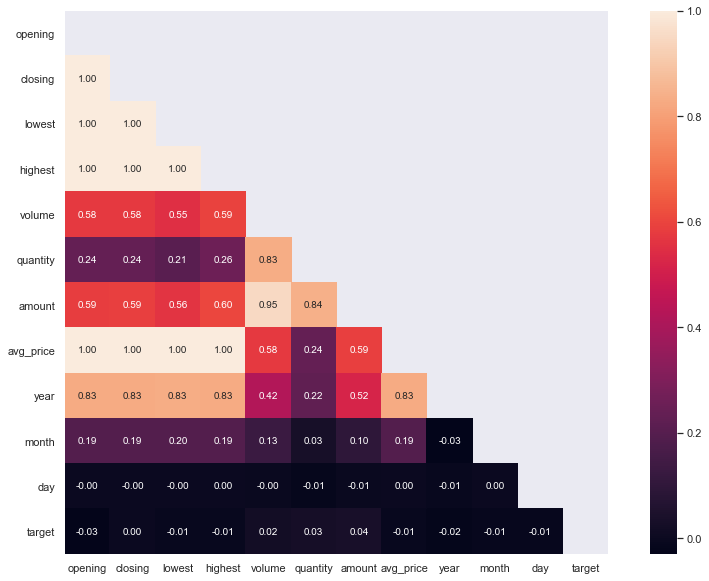

In [330]:
get_correlation(df_4)

### 6 - Excluindo colunas com alta correlação e não contribuirão para a análise

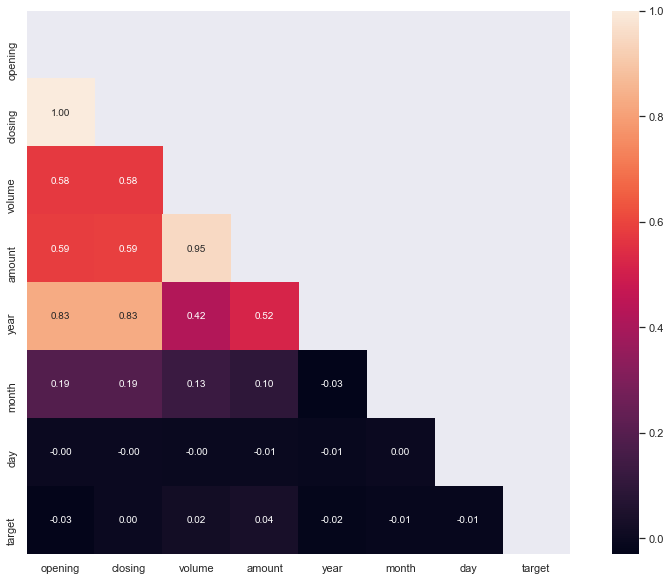

In [331]:
columns_to_remove = ['lowest', 'highest', 'quantity', 'avg_price']
df_5 = df_4.drop(columns = columns_to_remove)
get_correlation(df_5)

### 7 - Carregando dados de BTC juntamente com os indices 

In [332]:
df_6 = get_data_from_db()
df_6.index = df_6['date']
df_7 = break_date(df_6, 'date')
df_7['target'] = np.where(df_7['btcopening'] >= df_7['btcclosing'], 1, 0)
df_7.head()

,btcopening,btcclosing,btcquantity,btcamount,daxopening,daxclosing,daxlowest,daxhighest,djiopening,djiclosing,djilowest,djihighest,hsiopening,hsiclosing,hsilowest,hsihighest,year,month,day,target
date,,,,,,,,,,,,,,,,,,,,
2015-01-02,885.00000,921.84715,76.619064,219.0,23.260702,23.260702,23.260702,23.260702,17833.000000,17833.000000,17833.000000,17833.000000,23857.800781,23857.800781,23857.800781,23857.800781,2015,1,2,0
2015-01-05,806.00001,788.00000,77.536312,196.0,22.982425,22.120028,22.120028,22.982425,17501.699219,17501.699219,17501.699219,17501.699219,23721.300781,23721.300781,23721.300781,23721.300781,2015,1,5,1
2015-01-06,788.00002,869.96999,75.642620,277.0,22.120028,22.120028,22.120028,22.120028,17371.599609,17371.599609,17371.599609,17371.599609,23485.400391,23485.400391,23485.400391,23485.400391,2015,1,6,0
2015-01-07,869.96999,894.37342,128.782582,364.0,22.120028,22.120028,22.120028,22.120028,17584.500000,17584.500000,17584.500000,17584.500000,23681.300781,23681.300781,23681.300781,23681.300781,2015,1,7,0
2015-01-08,912.07042,905.98343,117.252409,326.0,22.617903,22.742373,22.617903,22.742373,17907.900391,17907.900391,17907.900391,17907.900391,23835.500000,23835.500000,23835.500000,23835.500000,2015,1,8,1


In [333]:
#compression_opts = dict(method='zip', archive_name='bdcsv.csv')  
#df_7.to_csv('bdcsv.zip', index=False, compression=compression_opts)

### 8 - Verificando a Correlação e excluindo características que não contribuem para o processo

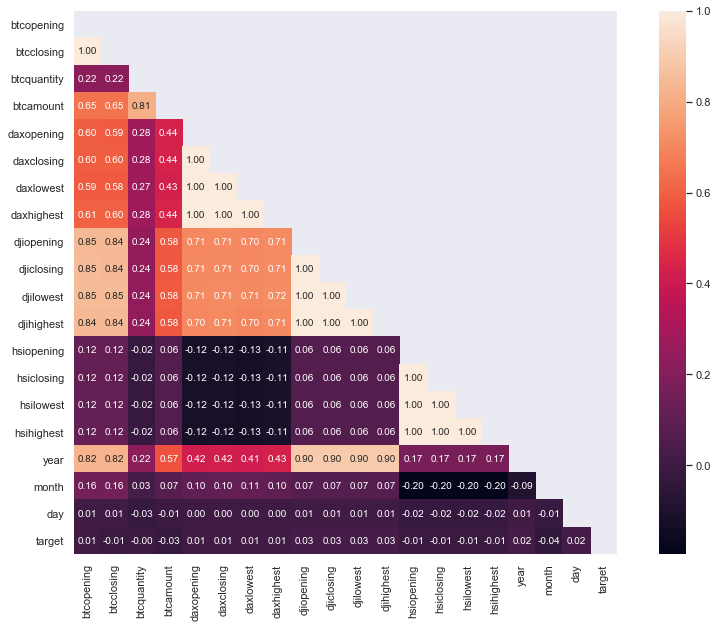

In [334]:
get_correlation(df_7)

In [335]:
columns_to_remove = ['lowest', 'highest', 'opening']
new_c_to_remove = []
for col in columns_to_remove:
    for stk in stock_array: 
        new_c_to_remove.append(f"{stk.lower()}{col}")
    for crypto in stock_array: 
        new_c_to_remove.append(f"{crypto.lower()}{col}")
df_8 = df_7.drop(columns = np.array(new_c_to_remove))


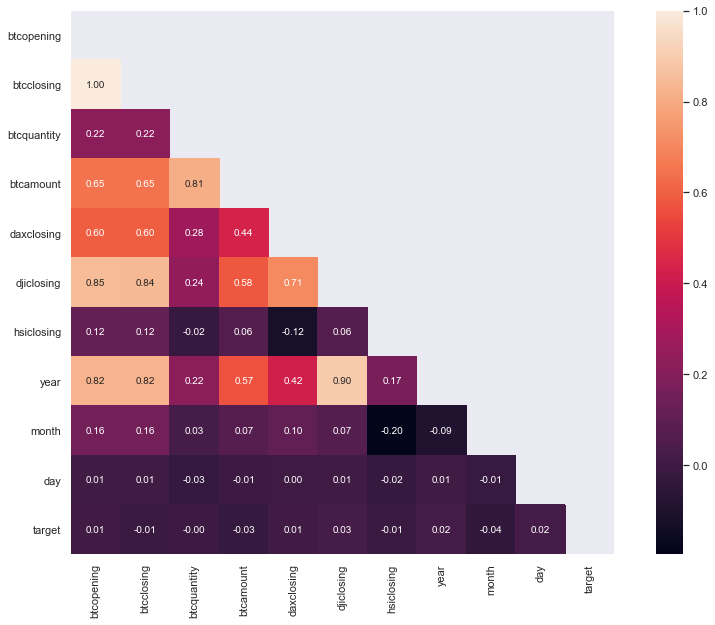

In [336]:
get_correlation(df_8)

### 9 - Criando um dataset somente dos fechamentos para verificar graficamente o comportamento da criptomoeda em relação aos índices

In [337]:
df_closing = pd.DataFrame(columns = ['btc', 'dji', 'dax', 'hsi','year', 'month', 'day'])
df_closing['btc'] = df_8['btcclosing']
df_closing['dji'] = df_8['djiclosing']
df_closing['dax'] = df_8['daxclosing']
df_closing['hsi'] = df_8['hsiclosing']
df_closing['year'] = df_8['year']
df_closing['month'] = df_8['month']
df_closing['day'] = df_8['day']
EDA(df_closing, True)

,Amount_NaN,%_NaN,DType,Amount_Data,Amount_Unique,Mean,Median,Max,Min,STD
btc,0,0.0,float64,1303,1282,18635.53,11180.00,103953.339050,550.000000,20963.00
dji,0,0.0,float64,1303,1167,21877.25,21636.80,30218.300781,15660.200195,3805.65
dax,0,0.0,float64,1303,31,25.04,24.74,31.583763,17.186836,2.86
hsi,0,0.0,float64,1303,1293,16380.43,22885.90,33154.101562,0.065000,12030.33
year,0,0.0,int64,1303,904,2017.24,2017.00,2020.000000,2015.000000,1.68
month,0,0.0,int64,1303,12,6.26,6.00,12.000000,1.000000,3.38
day,0,0.0,int64,1303,6,15.83,16.00,31.000000,1.000000,8.72


### 10 - Ajustando os valores e normalizando para plotagem em uma mesma esccala

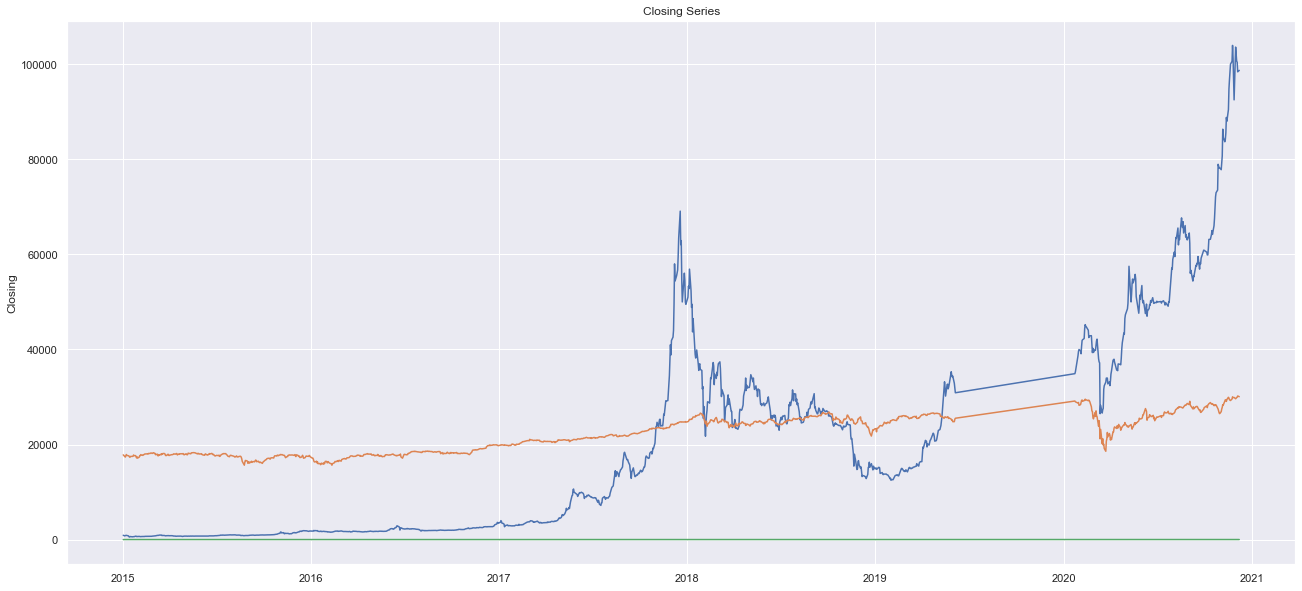

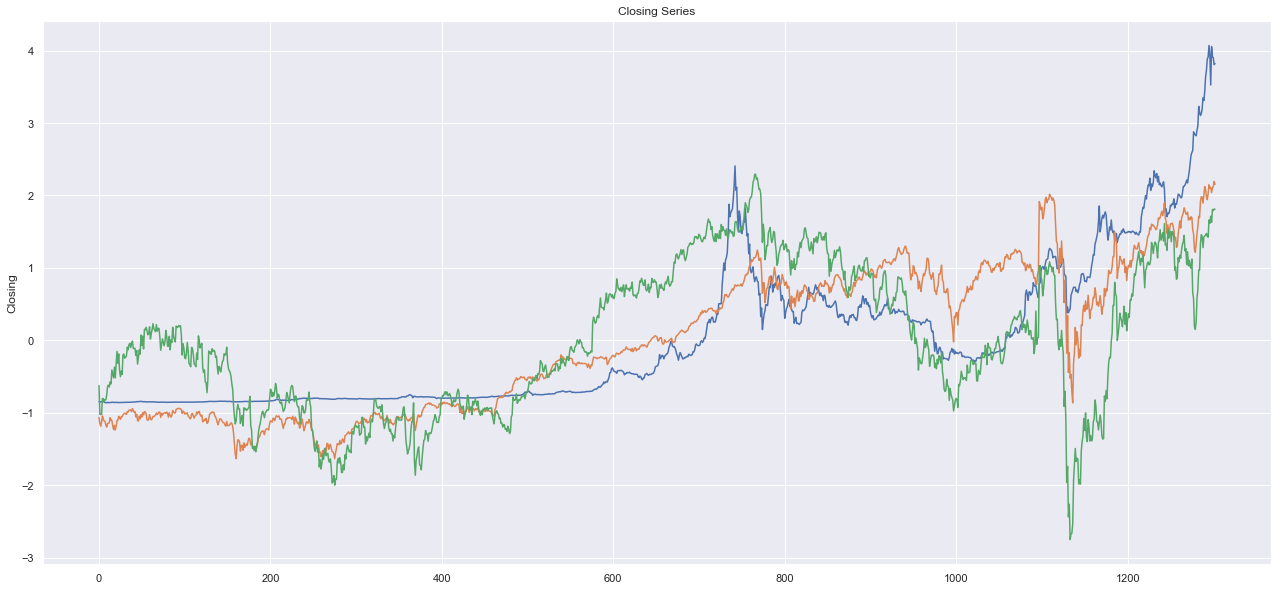

In [338]:
df_closing_scaler = pd.DataFrame(StandardScaler().fit(df_closing).fit_transform(df_closing), columns = df_closing.columns)
df_closing_scaler = df_closing_scaler.drop(columns = ['year', 'month', 'day'])
plot_stock_closing(df_closing)
plot_stock_closing(df_closing_scaler)

In [339]:
EDA(df_closing_scaler, True)

,Amount_NaN,%_NaN,DType,Amount_Data,Amount_Unique,Mean,Median,Max,Min,STD
btc,0,0.0,float64,1303,1282,-0.0,-0.36,4.071485,-0.863067,1.0
dji,0,0.0,float64,1303,1167,-0.0,-0.06,2.192596,-1.634266,1.0
dax,0,0.0,float64,1303,1293,0.0,-0.10,2.293460,-2.750994,1.0
hsi,0,0.0,float64,1303,904,0.0,0.54,1.394817,-1.362112,1.0


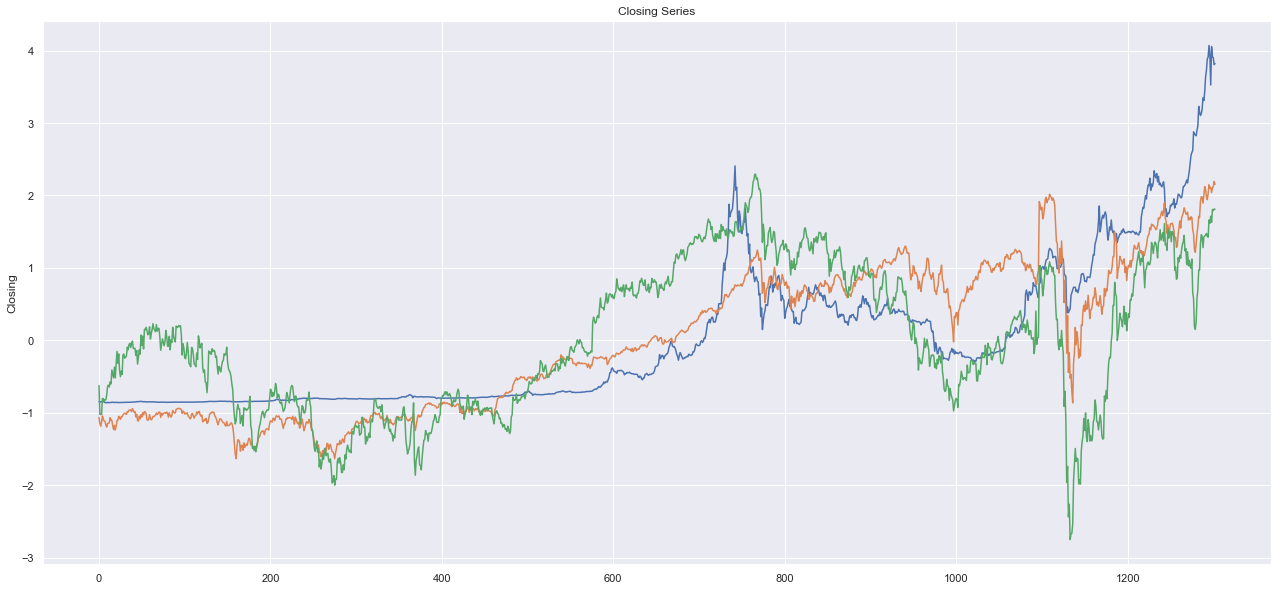

In [340]:
plot_stock_closing(df_closing_scaler)

### 11 - Decomposição de componentes de séries temporais

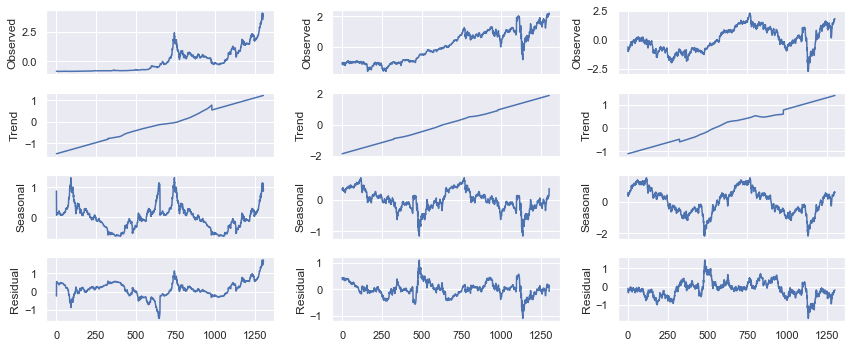

In [341]:
result_btc = seasonal_decompose(x=df_closing_scaler['btc'], model='additive', extrapolate_trend='freq', period=int(len(df_closing_scaler)/2))
result_dji = seasonal_decompose(x=df_closing_scaler['dji'], model='additive', extrapolate_trend='freq', period=int(len(df_closing_scaler)/2))
result_dax = seasonal_decompose(x=df_closing_scaler['dax'], model='additive', extrapolate_trend='freq', period=int(len(df_closing_scaler)/2))


fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(12,5))

plotseasonal(result_btc, axes[:,0])
plotseasonal(result_dji, axes[:,1])
plotseasonal(result_dax, axes[:,2])

plt.tight_layout()
plt.show()


### 11 - Construindo LagFeatures, um deslocamento temporal nos dados para verificar se o estado presente das características  é capaz de predizer o fechamento futuro do BTC

In [421]:
lag_days = [1,2,3,5]
lag_day = lag_days[3]
#btc_columns = ['btcopening', 'btcclosing', 'btcquantity', 'btcamount', 'target']
btc_columns = ['target']
idx_columns = df_8.columns.drop(btc_columns)
df_9_part1 = df_8[btc_columns]
#df_9_part1 = df_8[btc_columns]
df_9_part2 = df_8[idx_columns].shift(lag_day)   
df_9 = pd.concat([df_9_part2, df_9_part1], axis = 1).dropna()


### 12 - Definindo os modelos de Classificação

In [422]:
df_10 = df_9
df_10 = df_10.reset_index().drop(columns = ['date'])
#df_10.index = df_10.index.to_timestamp()
#df_10.index = df_10.index.to_period('D')
X = df_10.drop(columns = ['target'])
Y = df_10.target
#model = ARIMA(df_10[{'btcclosing'}], order=(5,1,0))
#model_fit = model.fit()
pca = PCA(n_components=5)
pca.fit(X)
X = pca.transform(X) 

In [ ]:
###Testando arima
tsp = TimeSeriesSplit()
TimeSeriesSplit(max_train_size=None, n_splits=int(len(X)/7))

sample_split = [3, 5, 30]

metrica_final_teste = []
metrica_final_treino = []
diff_final_metrica = []

for i in range (0, len(sample_split)):
    
    metrica_teste = []
    metrica_treino = []
    diff_metrica = []
    
    print ('calculando métricas para vizinhos: ', vizinhos[i])

    for train_index, test_index in tsp.split(X):
        x_treino, x_teste = X[train_index], X[test_index]
        y_treino, y_teste = Y[train_index], Y[test_index]

        scaler = StandardScaler().fit(x_treino)
        x_treino_norm = scaler.fit_transform(x_treino)
        x_teste_norm = scaler.fit_transform(x_teste)
        modelo_0 = ARIMA(x_treino[{'btcclosing'}], order=(5,1,0))
        modelo_1 = DecisionTreeClassifier(min_samples_split=sample_split[i], max_depth = 10).fit(x_treino_norm, y_treino)


        pred_treino = modelo_1.predict(x_treino_norm)
        pred_teste = modelo_1.predict(x_teste_norm)
        
        metrica_treino.append(f1_score(y_treino, pred_treino, average='micro'))
        metrica_teste.append(f1_score(y_teste, pred_teste, average='micro'))
        
        diff_metrica.append(100*np.abs((f1_score(y_treino, pred_treino, average='micro') - \
                                   f1_score(y_teste, pred_teste, average='micro'))/\
                                  f1_score(y_teste, pred_teste, average='micro')))
    
    metrica_final_teste.append(np.mean(metrica_teste))
    metrica_final_treino.append(np.mean(metrica_treino))
    diff_final_metrica.append(np.mean(diff_metrica))
print(metrica_final_teste)
print(metrica_final_treino)
print(diff_final_metrica)

In [423]:
tsp = TimeSeriesSplit()
TimeSeriesSplit(max_train_size=None, n_splits=int(len(X)/7))

sample_split = [3, 5, 30]

metrica_final_teste = []
metrica_final_treino = []
diff_final_metrica = []

for i in range (0, len(sample_split)):
    
    metrica_teste = []
    metrica_treino = []
    diff_metrica = []
    
    print ('calculando métricas para vizinhos: ', vizinhos[i])

    for train_index, test_index in tsp.split(X):
        x_treino, x_teste = X[train_index], X[test_index]
        y_treino, y_teste = Y[train_index], Y[test_index]

        scaler = StandardScaler().fit(x_treino)
        x_treino_norm = scaler.fit_transform(x_treino)
        x_teste_norm = scaler.fit_transform(x_teste)

        modelo_1 = DecisionTreeClassifier(min_samples_split=sample_split[i], max_depth = 10).fit(x_treino_norm, y_treino)


        pred_treino = modelo_1.predict(x_treino_norm)
        pred_teste = modelo_1.predict(x_teste_norm)
        
        metrica_treino.append(f1_score(y_treino, pred_treino, average='micro'))
        metrica_teste.append(f1_score(y_teste, pred_teste, average='micro'))
        
        diff_metrica.append(100*np.abs((f1_score(y_treino, pred_treino, average='micro') - \
                                   f1_score(y_teste, pred_teste, average='micro'))/\
                                  f1_score(y_teste, pred_teste, average='micro')))
    
    metrica_final_teste.append(np.mean(metrica_teste))
    metrica_final_treino.append(np.mean(metrica_treino))
    diff_final_metrica.append(np.mean(diff_metrica))
print(metrica_final_teste)
print(metrica_final_treino)
print(diff_final_metrica)

calculando métricas para vizinhos:  5
calculando métricas para vizinhos:  10
calculando métricas para vizinhos:  30
[0.525, 0.5203703703703704, 0.5203703703703704]
[0.765321850140958, 0.7610749939824872, 0.706742665834]
[45.72938055487158, 46.66358734258423, 35.971474555829154]


In [424]:
vizinhos = [5, 10,30]
metrica_final_teste = []
metrica_final_treino = []
diff_final_metrica = []
for i in range (0, len(vizinhos)):
    
    metrica_teste = []
    metrica_treino = []
    diff_metrica = []
    
    print ('calculando métricas para vizinhos: ', vizinhos[i])

    for train_index, test_index in tsp.split(X):
        x_treino, x_teste = X[train_index], X[test_index]
        y_treino, y_teste = Y[train_index], Y[test_index]

        scaler = StandardScaler().fit(x_treino)
        x_treino_norm = scaler.fit_transform(x_treino)
        x_teste_norm = scaler.fit_transform(x_teste)

        modelo_2 = KNeighborsClassifier(n_neighbors=vizinhos[i]).fit(x_treino_norm, y_treino)



        pred_treino = modelo_2.predict(x_treino_norm)
        pred_teste = modelo_2.predict(x_teste_norm)
        
        metrica_treino.append(f1_score(y_treino, pred_treino, average='micro'))
        metrica_teste.append(f1_score(y_teste, pred_teste, average='micro'))
        
        diff_metrica.append(100*np.abs((f1_score(y_treino, pred_treino, average='micro') - \
                                   f1_score(y_teste, pred_teste, average='micro'))/\
                                  f1_score(y_teste, pred_teste, average='micro')))
    
    metrica_final_teste.append(np.mean(metrica_teste))
    metrica_final_treino.append(np.mean(metrica_treino))
    diff_final_metrica.append(np.mean(diff_metrica))
print(metrica_final_teste)
print(metrica_final_treino)
print(diff_final_metrica)

calculando métricas para vizinhos:  5
calculando métricas para vizinhos:  10
calculando métricas para vizinhos:  30
[0.5314814814814814, 0.5287037037037037, 0.5574074074074075]
[0.7073123527648957, 0.6537718984724682, 0.6058798670027683]
[33.58062038457207, 24.035115899408712, 8.844958202748154]


In [426]:
kernel_model = ['linear', 'poly', 'rbf', 'sigmoid'] 
metrica_final_teste = []
metrica_final_treino = []
diff_final_metrica = []
for i in range (0, len(kernel_model)):
    
    metrica_teste = []
    metrica_treino = []
    diff_metrica = []
    
    print ('calculando métricas para kernel_model: ', kernel_model[i])

    for train_index, test_index in tsp.split(X):
        x_treino, x_teste = X[train_index], X[test_index]
        y_treino, y_teste = Y[train_index], Y[test_index]
        scaler = StandardScaler().fit(x_treino)
        x_treino_norm = scaler.fit_transform(x_treino)
        x_teste_norm = scaler.fit_transform(x_teste)

        modelo_3 = SVC(kernel=kernel_model[i]).fit(x_treino_norm, y_treino)




        pred_treino = modelo_3.predict(x_treino_norm)
        pred_teste = modelo_3.predict(x_teste_norm)
        
        metrica_treino.append(f1_score(y_treino, pred_treino, average='micro'))
        metrica_teste.append(f1_score(y_teste, pred_teste, average='micro'))
        
        diff_metrica.append(100*np.abs((f1_score(y_treino, pred_treino, average='micro') - \
                                   f1_score(y_teste, pred_teste, average='micro'))/\
                                  f1_score(y_teste, pred_teste, average='micro')))
    
    metrica_final_teste.append(np.mean(metrica_teste))
    metrica_final_treino.append(np.mean(metrica_treino))
    diff_final_metrica.append(np.mean(diff_metrica))
print(metrica_final_teste)
print(metrica_final_treino)
print(diff_final_metrica)

calculando métricas para kernel_model:  linear
calculando métricas para kernel_model:  poly
calculando métricas para kernel_model:  rbf
calculando métricas para kernel_model:  sigmoid
[0.5722222222222222, 0.5685185185185185, 0.5638888888888889, 0.5462962962962963]
[0.5913841617760649, 0.615583871939616, 0.6180930088347267, 0.5272385538069709]
[8.527111449847153, 10.027772222102225, 11.393294105651382, 7.4441205875597065]


In [427]:
metrica_final_treino

[0.5913841617760649, 0.615583871939616, 0.6180930088347267, 0.5272385538069709]

In [355]:
diff_final_metrica

[4.784606226004973, 11.862826890934155, 10.303979470521138, 8.08613351183716]